# Galaxy Mass
* The attenuation is not involved at this point.

# -----> Finding the mass distribution using the curve of growth.
* Just subtract the fluxes between each 2 from the curve of growth and divide them by the area (differential form ---> (lim(f2)-lim(f1))/(area2-area1)). f represents the flux down here.
* Remeber that most of the codes here are from the `Galaxy_surface_brightness` file

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import sep

# A&A specific settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], # A&A uses a Times-based font
    "axes.labelsize": 20,    # Standard size for A&A captions/labels
    "font.size": 20,
    "legend.fontsize": 17,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "text.latex.preamble": r"\usepackage{txfonts}" # This matches the A&A math style
})

path_galaxy = "Bicocca-Tele.data/ngc_6946_for_29th_Sep_2025/LIGHT"

Find the Differentail form out of the fluxes. Dif(fluxes)/Dif(annulus). The annulus is the area of the annulus.

In [32]:
with fits.open(path_galaxy + "/master_galaxy_I.fits") as hdu: 
    data = hdu[0].data

position_x , position_y = 2250 ,  2250
position = (position_x,position_y)
aperture = CircularAperture(position, r= 550)
annulus_aperture = CircularAnnulus(position, r_in=650, r_out=800)


mask = np.zeros(data.shape , dtype= bool)
mask[ 1870:1900 , 2280:2320 ] = True
mask[ 1590:1630 , 2155:2195 ] = True
mask[ 1655:1730 , 2370:2440 ] = True
mask[ 2650:2690 , 2570:2620 ] = True
mask[ 1700:1770 , 2000:2099 ] = True
mask[ 2410:2459 , 1700:1770 ] = True
mask[ 2500:2550 , 1525:1575 ] = True
mask[ 2000:2100 , 1650:1750 ] = True

data = np.ma.array(data, mask=mask) # Applying the mask on data

data = data.astype(data.dtype.newbyteorder('='))
bkg = sep.Background(data.data.astype(np.float64))
rms = bkg.rms()

radius = np.arange(1,650,30)
fluxes = []
for r in radius:
    aperture = CircularAperture(position, r=r)         # Measuring the flux of the selected radius.(The galaxy)
    annulus = annulus_aperture                         # Measuring the sky background which is out of the galaxy range
    phot_table = aperture_photometry(data, [aperture, annulus])   # Sums pixels values of aperture and annulus. Return a table of the sum
    aperture_sum = phot_table['aperture_sum_0'][0]
    annulus_sum = phot_table['aperture_sum_1'][0]
    bkg_per_pix = annulus_sum / annulus.area                # Average background per pixel
    total_bkg = bkg_per_pix * aperture.area                 # estimate background flux inside the aperture
    net_flux = aperture_sum - total_bkg
    fluxes.append(net_flux)                # !! Correct flux value!! Check the Sky subtraction file....

#  ++++ Evaluating the flux and area differences with the corresponding avg.radius ++++
new_fluxes = []
for i in range(len(fluxes)-1):
    difference = fluxes[i+1] - fluxes[i]
    new_fluxes.append(difference)
new_fluxes = np.array(new_fluxes)     # We can't modify it using the list form !!!!

new_areas= []
for i in range(len(radius)-1):
    difference = np.pi*(radius[i+1])**2 - np.pi*(radius[i])**2
    new_areas.append(difference)
new_areas = np.array(new_areas)

new_radius = []
for i in range(len(radius)-1):
    radii = radius[i]+(radius[i+1] - radius[i])/2
    new_radius.append(radii)
new_radius = np.array(new_radius)    
len(new_radius)


21

### Each time you change the galaxy filter, run only one of the next 3 lists depending on the name.

In [8]:
flux_g = new_fluxes
differentiation_g = flux_g*(10**(A_g/2.5))/new_areas
len(flux_g)

21

In [6]:
flux_r = new_fluxes
differentiation_r = flux_r*(10**(A_r/2.5))/new_areas
len(flux_r)

21

In [33]:
flux_i = new_fluxes
differentiation_i = flux_i/new_areas
len(flux_i)

21

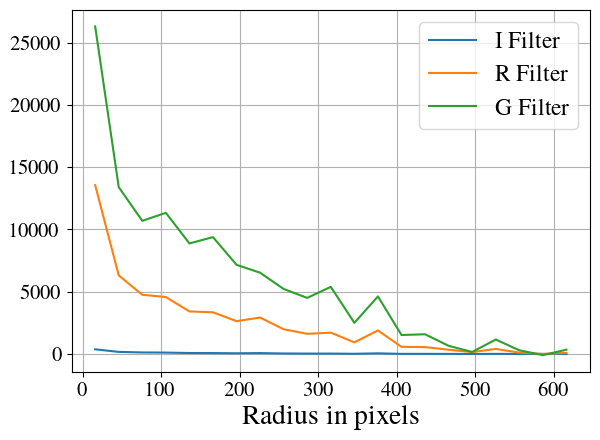

In [34]:
plt.plot(new_radius,differentiation_i, label= 'I Filter')
plt.plot(new_radius,differentiation_r, label= 'R Filter')
plt.plot(new_radius,differentiation_g, label= 'G Filter')
plt.legend()
# plt.title('Galaxy Flux per unit area')
# plt.ylabel('flux_differ/area in erg/s/cm^2/pixels^2')
plt.xlabel('Radius in pixels')
plt.grid()
plt.tight_layout()
plt.show()


Using the I filter data would give negative color values as it start higher than R and G then decrease below them. I prefer not to use it.

# VERY IMPORTANT REGARDING THE USED COLOR
The best choice of color is the redder one( The one uses i filter): Like g-i or r-i or u-i
u or g have a large value of error and the reason:
* ` For short wavelengths, the dust absorption increases which lead to higher error value. The r and i observe the galaxy with less dust absorption.`

Reference: https://iopscience.iop.org/article/10.1086/378847   (Eric F.Bell)


C:\Users\demet\AppData\Local\Temp\ipykernel_11736\2744901847.py:11: RuntimeWarning: invalid value encountered in log10
  color = -2.5*np.log10((flux_g)/(flux_r))
C:\Users\demet\AppData\Local\Temp\ipykernel_11736\2744901847.py:12: RuntimeWarning: invalid value encountered in log10
  color_i = -2.5*np.log10(flux_r/flux_i)


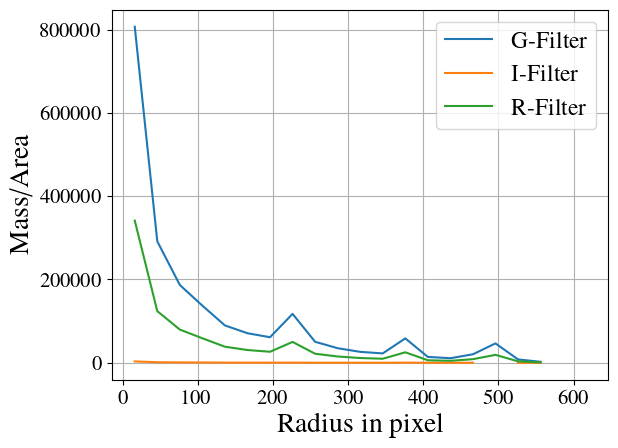

In [35]:
L_sun = 3.828 * 10**33                            # erg/s
M_sun = 1.988 * 10**33                            # gram
gal_dist = 5.545 *(10**6)* 3.0857*10**(18)        # We can have it directly from NED/NASA (It was in Mpc and now it's in cm)
area = 4*np.pi*(gal_dist**2)   # Area of the Galaxy sphere at gal_dist


# color_r_i = -2.5*np.log10(flux_r/flux_i)   # The i band is going above and below the r and the g values which would give a bad distribution
# a_i = 0.006
# b_i = 1.114

color = -2.5*np.log10((flux_g)/(flux_r))
color_i = -2.5*np.log10(flux_r/flux_i)

a_i = -0.222
b_i = 0.864
a_r = -0.306
b_r = 1.097
a_g = -0.499
b_g = 1.519 



# Remember to subtract the attenuation 
gal_mass_dist_i = (differentiation_i*1e-17*area/L_sun)*10**(a_i + b_i*color_i)
gal_mass_dist_r = (differentiation_r*1e-17*area/L_sun)*10**(a_r + b_r*color)    # GALAXY MASS DISTRIBUTION: it will be automatically in units of solar mass/pixels^2
gal_mass_dist_g = (differentiation_g*1e-17*area/L_sun)*10**(a_g + b_g*color)

plt.plot(new_radius, gal_mass_dist_g, label = "G-Filter")
plt.plot(new_radius, gal_mass_dist_i, label = "I-Filter")
plt.plot(new_radius, gal_mass_dist_r, label = "R-Filter")

plt.xlabel('Radius in pixel')
plt.ylabel('Mass/Area')
# plt.title('Galaxy Mass Distribution')
plt.legend()
plt.grid()
# plt.tight_layout()
plt.show()

In [36]:
tot_area = np.pi*500**2

A_r = 4.12
A_g = 5.5

gal_tot_mass_r =np.nansum(gal_mass_dist_r) * tot_area
print(f'{gal_tot_mass_r:.2e} Solar mass')
gal_tot_mass_g =np.nansum(gal_mass_dist_g) * tot_area
print(f'{gal_tot_mass_g:.2e} Solar mass') 
gal_tot_mass_i =np.nansum(gal_mass_dist_i) * tot_area
print(f'{gal_tot_mass_i:.2e} Solar mass') 

6.88e+11 Solar mass
1.62e+12 Solar mass
6.53e+09 Solar mass


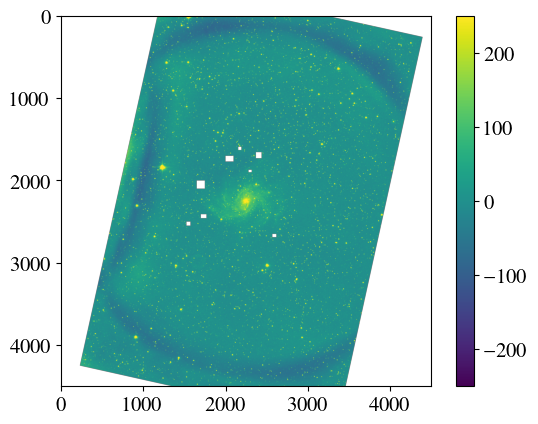

In [37]:
# This image is to show the issue with the i band filter.
plt.imshow(data, clim = (-250,250))
plt.colorbar()
plt.show()

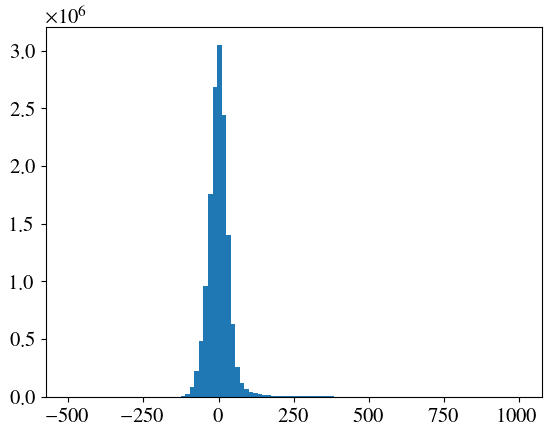

In [29]:
plt.hist(data.flatten(),bins =100,range=(-500,1000))
plt.show()